# Music Generator with LSTM

## About

Music resamples language as a temporal sequence of articulated sounds. They say something, often something human.

Although, there are crucial differences between language and music. We can still describe it as a sequence of symbols in the simplest form of understanding. Translating something complex into something simpler, but usable by computational models.

Thus, the objective of this project is to establish a communication between the human, that understands music in the most intense way that the brain can interpret through information, and the machine.

We'll create a model that can generate music based on the input information, i.e., generate a sequence of sounds which are related in some way with the sounds passed as input.

We'll use Natural Language Processing (NLP) methods, observing the music as it were a language, abstracting it. Doing this, the machine can recognize and process similar data.

On the first step, we'll use text generation techniques, using Recurrent Neural Networks (RNNs) and Long-Short Term Memories (LSTMs). With the effectiveness of the training, even if it's reasonable, we'll perform the same implementation using specific methods such as Attention.



## Imports

In [1]:
# Basic libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Preprocessing data libraries
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

# Model libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Data visualization
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm #for loading bars

# Utils
import music21
import pickle

c:\users\vitor\appdata\local\programs\python\python39\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
from encoder import *
from decoder import *

## Dataset

### Load data

In [4]:
data_path = '../data/'
out_encoded_path = '../encoded/'
out_decoded_path = '../decoded/'
file = 'C major scale'
in_file = data_path + file
out_encoded = out_encoded_path + file
out_decoded = out_decoded_path + file

N_FRAMES = 36
N_NOTES = 88
MIDI_OFFSET = 20

In [5]:
# be sure that the dirs exist
if not os.path.isdir(data_path):
    os.mkdir(data_path)
if not os.path.isdir(out_decoded_path):
    os.mkdir(out_decoded_path)
if not os.path.isdir(out_encoded_path):
    os.mkdir(out_encoded_path)

In [6]:
# get encoded data and save encoded file
encoded_song = encode_data(in_file,
                           N_FRAMES,
                           N_NOTES,
                           MIDI_OFFSET, 
                           save_as=out_encoded
                           )

Encoding file C_major_scale
Encoding Piano
Took 0.22095298767089844


### Data visualization

Each song is represented by a Pandas DataFrame where each column represents some song status. 

In [7]:
encoded_song

,inst_code,ks,bpm,ts,G#0,A0,B-0,B0,C1,C#1,...,D7,E-7,E7,F7,F#7,G7,G#7,A7,B-7,B7
inst,,,,,,,,,,,,,,,,,,,,,
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [8]:
test_piano_df = encoded_song[encoded_song.index=='Piano']
# test_bass_df = encoded_song[encoded_song.index=='Bass']
print(f'Number of frames: {len(test_piano_df.index)}')
print(f'Number of bars: {len(test_piano_df.index)//N_FRAMES}')
test_piano_df

Number of frames: 256
Number of bars: 8


,inst_code,ks,bpm,ts,G#0,A0,B-0,B0,C1,C#1,...,D7,E-7,E7,F7,F#7,G7,G#7,A7,B-7,B7
inst,,,,,,,,,,,,,,,,,,,,,
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(test_piano_df.iloc[5*36:6*36])

      inst_code ks    bpm   ts    G#0     A0    B-0     B0     C1    C#1  \
inst                                                                       
Piano         0  C  120.0  4/4  False  False  False  False  False  False   
Piano         0  C  120.0  4/4  False  False  False  False  False  False   
Piano         0  C  120.0  4/4  False  False  False  False  False  False   
Piano         0  C  120.0  4/4  False  False  False  False  False  False   
Piano         0  C  120.0  4/4  False  False  False  False  False  False   
Piano         0  C  120.0  4/4  False  False  False  False  False  False   
Piano         0  C  120.0  4/4  False  False  False  False  False  False   
Piano         0  C  120.0  4/4  False  False  False  False  False  False   
Piano         0  C  120.0  4/4  False  False  False  False  False  False   
Piano         0  C  120.0  4/4  False  False  False  False  False  False   
Piano         0  C  120.0  4/4  False  False  False  False  False  False   
Piano       

### Preprocess data

In [10]:
def get_stackframe(encoded_song, init_idx, final_idx, to_float=True):
    stackframe = encoded_song.iloc[init_idx:final_idx, 4:]
    stackframe = stackframe.to_numpy()

    # print(f'Stackframe shape: {stackframe.shape}')
    if to_float:
        stackframe.astype(float)
        stackframe = stackframe + 0.0

    return stackframe

In [11]:
def get_info(encoded_song, num_frames=N_FRAMES):
    infos = encoded_song.iloc[:num_frames, 0:4]
    return infos

In [12]:
infos = get_info(test_piano_df, len(test_piano_df))

In [13]:
import os
def create_dataset(root_dir, instrument, N_FRAMES=36):
    dataset = []
    for filename in os.listdir(root_dir):
        if filename.endswith('pkl'):
            infile = open(root_dir + filename,'rb')
            encoded_song = pickle.load(infile)
            infile.close()
            encoded_part = encoded_song[encoded_song.index==instrument]
            
            init_idx = 0
            final_idx = len(encoded_part)
            stackframe = get_stackframe(encoded_part, init_idx=init_idx, final_idx=final_idx)
            dataset.append(np.array(stackframe))
      
    return dataset

In [14]:
root_dir = '../encoded/'
instrument = 'Piano'

dataset = create_dataset(root_dir, instrument)
print(f'Dataset size: {len(dataset)} song(s)')
dataset[0]

Dataset size: 2 song(s)


array([[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       ...,
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]], dtype=object)

In [15]:
def split_dataset(dataset, n_frames=N_FRAMES):
    X = []
    y = []
    
    # create two arrays X, y with bars
    for song in dataset:
        # create the frame blocks shifted in one position
        for i in range(song.shape[0] - N_FRAMES):
            j = i + n_frames
            xa = song[i:j]
            ya = song[i+1:j+1]
            X.append(xa)
            y.append(ya)
        
    X = np.array(X, dtype='float64')
    y = np.array(y, dtype='float64')
    X = torch.from_numpy(X)
    y = torch.from_numpy(y)
    print(f'X.shape, y.shape: {X.shape, y.shape}')
    train_ds = TensorDataset(X, y) # (X, y)
    return train_ds

In [16]:
train_ds = split_dataset(dataset)
train_dl = DataLoader(train_ds, batch_size=1, shuffle=False)

X.shape, y.shape: (torch.Size([264, 32, 88]), torch.Size([264, 32, 88]))


In [17]:
torch.set_printoptions(threshold=10_000)
x_ds = train_ds[180][0]
y = train_ds[180][1]

x = test_piano_df.iloc[5*36:6*36]
x.A5

inst
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Name: A5, dtype: object

## Model

Some important definitions

In [18]:
windows_size = N_FRAMES
keyboard_size = 88
n_bars_input = len(train_dl.dataset.tensors[0]) # number of rows of the dataloader
num_layers = 4
hidden_size = 88
num_epochs = 3
batch_size = 1
lr = 0.0003
print('Number of bars in the input dataset: {}'.format(n_bars_input))

Number of bars in the input dataset: 264


In [19]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    #self.embed = nn.Embedding(input_size, hidden_size)
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=False, bidirectional=True)
    self.fc1 = nn.Linear(hidden_size*2, hidden_size*2)
    self.fc2 = nn.Linear(hidden_size*2, output_size)
    self.relu = nn.ReLU()
    self.softplus = nn.Softplus(beta=500, threshold=0)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x, hidden, cell):

    # Passing in the input and hidden state into the model and obtaining outputs
    out, (hidden, cell) = self.lstm(x.unsqueeze(1), (hidden, cell))

    # Reshaping the outputs such that it can be fit into the fully connected layer
    #print(torch.squeeze(out[-1]))
    out = out.contiguous().view(-1, self.hidden_size*2)
    #print('Shape2: ',out.shape)
    # out = self.fc1(out)
    #print('Shape3: ',out.shape)
    # out = self.softplus(out)
    out = self.fc2(out)
    out = self.sigmoid(out)
    
    return out, (hidden, cell)

  def init_hidden(self, batch_size):
    # This method generates the first hidden state of zeros which we'll use in the forward pass
    # We'll send the tensor holding the hidden state to the device we specified earlier as well
    hidden = torch.zeros(self.num_layers*2, batch_size, self.hidden_size).to(device)
    cell = torch.zeros(self.num_layers*2, batch_size, self.hidden_size).to(device)
    return hidden, cell

In [20]:
# Instantiate the model with hyperparameters
# We'll also set the model to the device that we defined earlier (default is CPU)
model = RNN(input_size=keyboard_size,
                   output_size=keyboard_size,
                   hidden_size=hidden_size,
                   num_layers=num_layers).to(device)

In [21]:
print(model)


RNN(
  (lstm): LSTM(88, 88, num_layers=4, bidirectional=True)
  (fc1): Linear(in_features=176, out_features=176, bias=True)
  (fc2): Linear(in_features=176, out_features=88, bias=True)
  (relu): ReLU()
  (softplus): Softplus(beta=500, threshold=0)
  (sigmoid): Sigmoid()
)


## Train

In [22]:
# converts one frame into torch tensor
def multi_hot_tensor(frame):
  tensor = torch.from_numpy(frame)
  return tensor

In [23]:
# retrieve data from dataloader
def get_sample(dataloader):

  input = torch.zeros(n_bars_input, windows_size, keyboard_size)
  target = torch.zeros(n_bars_input, windows_size, keyboard_size)

  for sample, (xb, yb) in enumerate(dataloader): # gets the samples
    input[sample] = xb
    target[sample] = yb
  
  return input, target

In [24]:
def train(model, optimizer, loss_fn, dataloader, batch_size=1, num_epochs=3):
    writer = SummaryWriter()

    print("\nStarting training...")

    for epoch in range(1, num_epochs + 1):
        count = 0
        training_loss = 0.0

        print('> EPOCH #', epoch)

        input, target = get_sample(dataloader)
        input = input.to(device)
        target = target.to(device)
        
        # Initialize hidden and cells
        hidden, cell = model.init_hidden(batch_size)

        for fb_i in tqdm(range(len(train_dl.dataset.tensors[0]))):


            # Generate predictions
            frame_block = input[fb_i,:]
            output, (hidden, cell) = model(frame_block, hidden, cell)
            
            #if count%36 == 0:
                #print(f'Input {frame_block}, \nTarget {target[fb_i, :]}')

            # Compute the loss and backpropag
            loss_step = loss_fn(output, target[fb_i, :])

            hidden = hidden.detach()
            cell = cell.detach()

            count += 1
            #if count%36 == 0:
                #print(f'Output {output}, \nTarget {target[fb_i, :]}')

            loss_step.backward() # Does backpropagation and calculates gradients
            optimizer.step() # Updates the weights accordingly
            optimizer.zero_grad() # Clears existing gradients from previous frame

            training_loss += loss_step.item()

        training_loss /= len(train_dl.dataset)
        writer.add_scalar("Loss/train", training_loss, epoch)

        if epoch%1 == 0:
          print('Epoch: {}/{}.............'.format(epoch, num_epochs), end=' ')
          print("Loss: {:.8f}".format(training_loss))

    writer.flush()
    writer.close()

In [25]:
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()
train(model, optimizer, loss_fn, train_dl, num_epochs=500)


Starting training...
> EPOCH # 1


100%|██████████| 264/264 [00:25<00:00, 10.55it/s]


Epoch: 1/500............. Loss: 0.11137550
> EPOCH # 2


100%|██████████| 264/264 [00:23<00:00, 11.27it/s]


Epoch: 2/500............. Loss: 0.03707165
> EPOCH # 3


100%|██████████| 264/264 [00:25<00:00, 10.41it/s]


Epoch: 3/500............. Loss: 0.03609111
> EPOCH # 4


100%|██████████| 264/264 [00:23<00:00, 11.28it/s]


Epoch: 4/500............. Loss: 0.03577251
> EPOCH # 5


100%|██████████| 264/264 [00:24<00:00, 10.97it/s]


Epoch: 5/500............. Loss: 0.03563009
> EPOCH # 6


100%|██████████| 264/264 [00:23<00:00, 11.47it/s]


Epoch: 6/500............. Loss: 0.03554288
> EPOCH # 7


100%|██████████| 264/264 [00:23<00:00, 11.28it/s]


Epoch: 7/500............. Loss: 0.03554882
> EPOCH # 8


100%|██████████| 264/264 [00:22<00:00, 11.94it/s]


Epoch: 8/500............. Loss: 0.03555751
> EPOCH # 9


100%|██████████| 264/264 [00:22<00:00, 11.83it/s]


Epoch: 9/500............. Loss: 0.03557906
> EPOCH # 10


100%|██████████| 264/264 [00:21<00:00, 12.40it/s]


Epoch: 10/500............. Loss: 0.03551140
> EPOCH # 11


100%|██████████| 264/264 [00:20<00:00, 12.79it/s]


Epoch: 11/500............. Loss: 0.03554950
> EPOCH # 12


100%|██████████| 264/264 [00:19<00:00, 13.49it/s]


Epoch: 12/500............. Loss: 0.03546104
> EPOCH # 13


100%|██████████| 264/264 [00:21<00:00, 12.29it/s]


Epoch: 13/500............. Loss: 0.03550899
> EPOCH # 14


100%|██████████| 264/264 [00:19<00:00, 13.29it/s]


Epoch: 14/500............. Loss: 0.03561404
> EPOCH # 15


100%|██████████| 264/264 [00:20<00:00, 12.59it/s]


Epoch: 15/500............. Loss: 0.03562965
> EPOCH # 16


100%|██████████| 264/264 [00:19<00:00, 13.51it/s]


Epoch: 16/500............. Loss: 0.03563207
> EPOCH # 17


100%|██████████| 264/264 [00:21<00:00, 12.47it/s]


Epoch: 17/500............. Loss: 0.03566907
> EPOCH # 18


100%|██████████| 264/264 [00:20<00:00, 12.91it/s]


Epoch: 18/500............. Loss: 0.03581492
> EPOCH # 19


100%|██████████| 264/264 [00:18<00:00, 14.06it/s]


Epoch: 19/500............. Loss: 0.03572045
> EPOCH # 20


100%|██████████| 264/264 [00:19<00:00, 13.77it/s]


Epoch: 20/500............. Loss: 0.03568299
> EPOCH # 21


100%|██████████| 264/264 [00:18<00:00, 14.02it/s]


Epoch: 21/500............. Loss: 0.03588597
> EPOCH # 22


100%|██████████| 264/264 [00:18<00:00, 13.95it/s]


Epoch: 22/500............. Loss: 0.03561183
> EPOCH # 23


100%|██████████| 264/264 [00:20<00:00, 12.83it/s]


Epoch: 23/500............. Loss: 0.03527585
> EPOCH # 24


100%|██████████| 264/264 [00:19<00:00, 13.58it/s]


Epoch: 24/500............. Loss: 0.03631100
> EPOCH # 25


100%|██████████| 264/264 [00:19<00:00, 13.84it/s]


Epoch: 25/500............. Loss: 0.03597747
> EPOCH # 26


100%|██████████| 264/264 [00:19<00:00, 13.89it/s]


Epoch: 26/500............. Loss: 0.03576879
> EPOCH # 27


100%|██████████| 264/264 [00:20<00:00, 12.81it/s]


Epoch: 27/500............. Loss: 0.03574168
> EPOCH # 28


100%|██████████| 264/264 [00:19<00:00, 13.47it/s]


Epoch: 28/500............. Loss: 0.03574102
> EPOCH # 29


100%|██████████| 264/264 [00:18<00:00, 13.96it/s]


Epoch: 29/500............. Loss: 0.03120371
> EPOCH # 30


100%|██████████| 264/264 [00:21<00:00, 12.53it/s]


Epoch: 30/500............. Loss: 0.02928493
> EPOCH # 31


100%|██████████| 264/264 [00:18<00:00, 13.94it/s]


Epoch: 31/500............. Loss: 0.02261351
> EPOCH # 32


100%|██████████| 264/264 [00:19<00:00, 13.79it/s]


Epoch: 32/500............. Loss: 0.02109129
> EPOCH # 33


100%|██████████| 264/264 [00:18<00:00, 13.94it/s]


Epoch: 33/500............. Loss: 0.02367223
> EPOCH # 34


100%|██████████| 264/264 [00:19<00:00, 13.56it/s]


Epoch: 34/500............. Loss: 0.02105626
> EPOCH # 35


100%|██████████| 264/264 [00:18<00:00, 13.96it/s]


Epoch: 35/500............. Loss: 0.01936896
> EPOCH # 36


100%|██████████| 264/264 [00:24<00:00, 10.80it/s]


Epoch: 36/500............. Loss: 0.01976645
> EPOCH # 37


100%|██████████| 264/264 [00:31<00:00,  8.30it/s]


Epoch: 37/500............. Loss: 0.02182580
> EPOCH # 38


100%|██████████| 264/264 [00:24<00:00, 10.59it/s]


Epoch: 38/500............. Loss: 0.02238856
> EPOCH # 39


100%|██████████| 264/264 [00:21<00:00, 12.21it/s]


Epoch: 39/500............. Loss: 0.02167689
> EPOCH # 40


100%|██████████| 264/264 [00:22<00:00, 11.54it/s]


Epoch: 40/500............. Loss: 0.02017575
> EPOCH # 41


100%|██████████| 264/264 [00:21<00:00, 12.02it/s]


Epoch: 41/500............. Loss: 0.02554024
> EPOCH # 42


100%|██████████| 264/264 [00:20<00:00, 13.04it/s]


Epoch: 42/500............. Loss: 0.02228475
> EPOCH # 43


100%|██████████| 264/264 [00:19<00:00, 13.54it/s]


Epoch: 43/500............. Loss: 0.02339685
> EPOCH # 44


100%|██████████| 264/264 [00:20<00:00, 13.14it/s]


Epoch: 44/500............. Loss: 0.02463894
> EPOCH # 45


100%|██████████| 264/264 [00:19<00:00, 13.51it/s]


Epoch: 45/500............. Loss: 0.02555570
> EPOCH # 46


100%|██████████| 264/264 [00:19<00:00, 13.45it/s]


Epoch: 46/500............. Loss: 0.02298632
> EPOCH # 47


100%|██████████| 264/264 [00:19<00:00, 13.49it/s]


Epoch: 47/500............. Loss: 0.02447697
> EPOCH # 48


100%|██████████| 264/264 [00:21<00:00, 12.08it/s]


Epoch: 48/500............. Loss: 0.02411754
> EPOCH # 49


100%|██████████| 264/264 [00:25<00:00, 10.32it/s]


Epoch: 49/500............. Loss: 0.02354594
> EPOCH # 50


100%|██████████| 264/264 [00:22<00:00, 11.65it/s]


Epoch: 50/500............. Loss: 0.02424468
> EPOCH # 51


100%|██████████| 264/264 [00:20<00:00, 13.00it/s]


Epoch: 51/500............. Loss: 0.02059521
> EPOCH # 52


100%|██████████| 264/264 [00:20<00:00, 12.88it/s]


Epoch: 52/500............. Loss: 0.02041804
> EPOCH # 53


100%|██████████| 264/264 [00:19<00:00, 13.54it/s]


Epoch: 53/500............. Loss: 0.02068767
> EPOCH # 54


100%|██████████| 264/264 [00:19<00:00, 13.22it/s]


Epoch: 54/500............. Loss: 0.01759578
> EPOCH # 55


100%|██████████| 264/264 [00:21<00:00, 12.32it/s]


Epoch: 55/500............. Loss: 0.01416908
> EPOCH # 56


100%|██████████| 264/264 [00:20<00:00, 13.17it/s]


Epoch: 56/500............. Loss: 0.01171225
> EPOCH # 57


100%|██████████| 264/264 [00:23<00:00, 11.18it/s]


Epoch: 57/500............. Loss: 0.00896600
> EPOCH # 58


100%|██████████| 264/264 [00:20<00:00, 12.83it/s]


Epoch: 58/500............. Loss: 0.00647322
> EPOCH # 59


100%|██████████| 264/264 [00:20<00:00, 12.75it/s]


Epoch: 59/500............. Loss: 0.00466686
> EPOCH # 60


100%|██████████| 264/264 [00:20<00:00, 12.75it/s]


Epoch: 60/500............. Loss: 0.00346329
> EPOCH # 61


100%|██████████| 264/264 [00:20<00:00, 12.91it/s]


Epoch: 61/500............. Loss: 0.00278647
> EPOCH # 62


100%|██████████| 264/264 [00:20<00:00, 13.10it/s]


Epoch: 62/500............. Loss: 0.00211656
> EPOCH # 63


100%|██████████| 264/264 [00:20<00:00, 13.10it/s]


Epoch: 63/500............. Loss: 0.00160243
> EPOCH # 64


100%|██████████| 264/264 [00:20<00:00, 13.15it/s]


Epoch: 64/500............. Loss: 0.00130920
> EPOCH # 65


100%|██████████| 264/264 [00:20<00:00, 12.61it/s]


Epoch: 65/500............. Loss: 0.00110306
> EPOCH # 66


100%|██████████| 264/264 [00:20<00:00, 13.06it/s]


Epoch: 66/500............. Loss: 0.00089258
> EPOCH # 67


100%|██████████| 264/264 [00:21<00:00, 12.39it/s]


Epoch: 67/500............. Loss: 0.00082416
> EPOCH # 68


100%|██████████| 264/264 [00:20<00:00, 13.01it/s]


Epoch: 68/500............. Loss: 0.00066675
> EPOCH # 69


100%|██████████| 264/264 [00:23<00:00, 11.45it/s]


Epoch: 69/500............. Loss: 0.00058497
> EPOCH # 70


100%|██████████| 264/264 [00:20<00:00, 13.12it/s]


Epoch: 70/500............. Loss: 0.00047544
> EPOCH # 71


100%|██████████| 264/264 [00:20<00:00, 13.09it/s]


Epoch: 71/500............. Loss: 0.00037441
> EPOCH # 72


100%|██████████| 264/264 [00:20<00:00, 13.14it/s]


Epoch: 72/500............. Loss: 0.00035724
> EPOCH # 73


100%|██████████| 264/264 [00:20<00:00, 12.95it/s]


Epoch: 73/500............. Loss: 0.00041349
> EPOCH # 74


100%|██████████| 264/264 [00:18<00:00, 14.20it/s]


Epoch: 74/500............. Loss: 0.00031521
> EPOCH # 75


100%|██████████| 264/264 [00:18<00:00, 14.09it/s]


Epoch: 75/500............. Loss: 0.00025393
> EPOCH # 76


100%|██████████| 264/264 [00:18<00:00, 14.21it/s]


Epoch: 76/500............. Loss: 0.00022717
> EPOCH # 77


100%|██████████| 264/264 [00:20<00:00, 13.18it/s]


Epoch: 77/500............. Loss: 0.00020416
> EPOCH # 78


100%|██████████| 264/264 [00:20<00:00, 12.69it/s]


Epoch: 78/500............. Loss: 0.00021113
> EPOCH # 79


100%|██████████| 264/264 [00:20<00:00, 12.99it/s]


Epoch: 79/500............. Loss: 0.00018656
> EPOCH # 80


100%|██████████| 264/264 [00:21<00:00, 12.04it/s]


Epoch: 80/500............. Loss: 0.00023030
> EPOCH # 81


100%|██████████| 264/264 [00:20<00:00, 12.90it/s]


Epoch: 81/500............. Loss: 0.00019779
> EPOCH # 82


100%|██████████| 264/264 [00:20<00:00, 12.79it/s]


Epoch: 82/500............. Loss: 0.00018041
> EPOCH # 83


100%|██████████| 264/264 [00:20<00:00, 13.02it/s]


Epoch: 83/500............. Loss: 0.00015542
> EPOCH # 84


100%|██████████| 264/264 [00:20<00:00, 12.94it/s]


Epoch: 84/500............. Loss: 0.00016472
> EPOCH # 85


100%|██████████| 264/264 [00:21<00:00, 12.54it/s]


Epoch: 85/500............. Loss: 0.00016525
> EPOCH # 86


100%|██████████| 264/264 [00:20<00:00, 13.10it/s]


Epoch: 86/500............. Loss: 0.00017193
> EPOCH # 87


100%|██████████| 264/264 [00:20<00:00, 13.12it/s]


Epoch: 87/500............. Loss: 0.00026091
> EPOCH # 88


100%|██████████| 264/264 [00:19<00:00, 13.79it/s]


Epoch: 88/500............. Loss: 0.00015756
> EPOCH # 89


100%|██████████| 264/264 [00:18<00:00, 14.13it/s]


Epoch: 89/500............. Loss: 0.00013444
> EPOCH # 90


100%|██████████| 264/264 [00:18<00:00, 13.96it/s]


Epoch: 90/500............. Loss: 0.00010804
> EPOCH # 91


100%|██████████| 264/264 [00:18<00:00, 14.19it/s]


Epoch: 91/500............. Loss: 0.00009324
> EPOCH # 92


100%|██████████| 264/264 [00:18<00:00, 14.16it/s]


Epoch: 92/500............. Loss: 0.00009330
> EPOCH # 93


100%|██████████| 264/264 [00:18<00:00, 14.21it/s]


Epoch: 93/500............. Loss: 0.00011911
> EPOCH # 94


100%|██████████| 264/264 [00:18<00:00, 14.21it/s]


Epoch: 94/500............. Loss: 0.00014272
> EPOCH # 95


100%|██████████| 264/264 [00:18<00:00, 14.19it/s]


Epoch: 95/500............. Loss: 0.00018036
> EPOCH # 96


100%|██████████| 264/264 [00:18<00:00, 14.08it/s]


Epoch: 96/500............. Loss: 0.00011475
> EPOCH # 97


100%|██████████| 264/264 [00:18<00:00, 14.22it/s]


Epoch: 97/500............. Loss: 0.00007458
> EPOCH # 98


100%|██████████| 264/264 [00:18<00:00, 14.12it/s]


Epoch: 98/500............. Loss: 0.00006397
> EPOCH # 99


100%|██████████| 264/264 [00:18<00:00, 14.24it/s]


Epoch: 99/500............. Loss: 0.00007504
> EPOCH # 100


100%|██████████| 264/264 [00:18<00:00, 14.12it/s]


Epoch: 100/500............. Loss: 0.00006938
> EPOCH # 101


100%|██████████| 264/264 [00:19<00:00, 13.80it/s]


Epoch: 101/500............. Loss: 0.00006675
> EPOCH # 102


100%|██████████| 264/264 [00:18<00:00, 14.18it/s]


Epoch: 102/500............. Loss: 0.00009015
> EPOCH # 103


100%|██████████| 264/264 [00:18<00:00, 13.92it/s]


Epoch: 103/500............. Loss: 0.00006466
> EPOCH # 104


100%|██████████| 264/264 [00:18<00:00, 14.15it/s]


Epoch: 104/500............. Loss: 0.00005125
> EPOCH # 105


100%|██████████| 264/264 [00:18<00:00, 14.35it/s]


Epoch: 105/500............. Loss: 0.00004490
> EPOCH # 106


100%|██████████| 264/264 [00:18<00:00, 14.30it/s]


Epoch: 106/500............. Loss: 0.00003751
> EPOCH # 107


100%|██████████| 264/264 [00:18<00:00, 14.41it/s]


Epoch: 107/500............. Loss: 0.00005231
> EPOCH # 108


100%|██████████| 264/264 [00:18<00:00, 14.28it/s]


Epoch: 108/500............. Loss: 0.00004189
> EPOCH # 109


100%|██████████| 264/264 [00:24<00:00, 10.77it/s]


Epoch: 109/500............. Loss: 0.00006124
> EPOCH # 110


100%|██████████| 264/264 [00:21<00:00, 12.10it/s]


Epoch: 110/500............. Loss: 0.00005085
> EPOCH # 111


100%|██████████| 264/264 [00:21<00:00, 12.38it/s]


Epoch: 111/500............. Loss: 0.00004167
> EPOCH # 112


100%|██████████| 264/264 [00:22<00:00, 11.98it/s]


Epoch: 112/500............. Loss: 0.00005136
> EPOCH # 113


100%|██████████| 264/264 [00:21<00:00, 12.01it/s]


Epoch: 113/500............. Loss: 0.00003032
> EPOCH # 114


100%|██████████| 264/264 [00:20<00:00, 12.58it/s]


Epoch: 114/500............. Loss: 0.00003202
> EPOCH # 115


100%|██████████| 264/264 [00:25<00:00, 10.20it/s]


Epoch: 115/500............. Loss: 0.00003531
> EPOCH # 116


100%|██████████| 264/264 [00:28<00:00,  9.34it/s]


Epoch: 116/500............. Loss: 0.00003688
> EPOCH # 117


100%|██████████| 264/264 [00:27<00:00,  9.67it/s]


Epoch: 117/500............. Loss: 0.00002232
> EPOCH # 118


100%|██████████| 264/264 [00:29<00:00,  9.06it/s]


Epoch: 118/500............. Loss: 0.00002905
> EPOCH # 119


100%|██████████| 264/264 [00:30<00:00,  8.59it/s]


Epoch: 119/500............. Loss: 0.00004144
> EPOCH # 120


100%|██████████| 264/264 [00:21<00:00, 12.12it/s]


Epoch: 120/500............. Loss: 0.00003932
> EPOCH # 121


100%|██████████| 264/264 [00:24<00:00, 10.62it/s]


Epoch: 121/500............. Loss: 0.00002709
> EPOCH # 122


100%|██████████| 264/264 [00:27<00:00,  9.61it/s]


Epoch: 122/500............. Loss: 0.00004449
> EPOCH # 123


100%|██████████| 264/264 [00:21<00:00, 12.07it/s]


Epoch: 123/500............. Loss: 0.00009400
> EPOCH # 124


100%|██████████| 264/264 [00:20<00:00, 12.97it/s]


Epoch: 124/500............. Loss: 0.00004663
> EPOCH # 125


100%|██████████| 264/264 [00:23<00:00, 11.31it/s]


Epoch: 125/500............. Loss: 0.00006091
> EPOCH # 126


100%|██████████| 264/264 [00:20<00:00, 13.02it/s]


Epoch: 126/500............. Loss: 0.00002996
> EPOCH # 127


100%|██████████| 264/264 [00:20<00:00, 13.01it/s]


Epoch: 127/500............. Loss: 0.00001755
> EPOCH # 128


100%|██████████| 264/264 [00:20<00:00, 12.92it/s]


Epoch: 128/500............. Loss: 0.00001478
> EPOCH # 129


100%|██████████| 264/264 [00:20<00:00, 12.84it/s]


Epoch: 129/500............. Loss: 0.00001135
> EPOCH # 130


100%|██████████| 264/264 [00:20<00:00, 12.86it/s]


Epoch: 130/500............. Loss: 0.00001183
> EPOCH # 131


100%|██████████| 264/264 [00:20<00:00, 13.06it/s]


Epoch: 131/500............. Loss: 0.00002331
> EPOCH # 132


100%|██████████| 264/264 [00:20<00:00, 12.71it/s]


Epoch: 132/500............. Loss: 0.00004295
> EPOCH # 133


100%|██████████| 264/264 [00:21<00:00, 12.40it/s]


Epoch: 133/500............. Loss: 0.00004283
> EPOCH # 134


100%|██████████| 264/264 [00:20<00:00, 13.03it/s]


Epoch: 134/500............. Loss: 0.00002239
> EPOCH # 135


100%|██████████| 264/264 [00:20<00:00, 12.98it/s]


Epoch: 135/500............. Loss: 0.00001713
> EPOCH # 136


100%|██████████| 264/264 [00:21<00:00, 12.52it/s]


Epoch: 136/500............. Loss: 0.00002944
> EPOCH # 137


100%|██████████| 264/264 [00:20<00:00, 13.13it/s]


Epoch: 137/500............. Loss: 0.00002359
> EPOCH # 138


100%|██████████| 264/264 [00:18<00:00, 14.25it/s]


Epoch: 138/500............. Loss: 0.00001751
> EPOCH # 139


100%|██████████| 264/264 [00:18<00:00, 14.30it/s]


Epoch: 139/500............. Loss: 0.00001540
> EPOCH # 140


100%|██████████| 264/264 [00:18<00:00, 14.17it/s]


Epoch: 140/500............. Loss: 0.00001812
> EPOCH # 141


100%|██████████| 264/264 [00:18<00:00, 14.23it/s]


Epoch: 141/500............. Loss: 0.00002670
> EPOCH # 142


100%|██████████| 264/264 [00:18<00:00, 14.29it/s]


Epoch: 142/500............. Loss: 0.00002118
> EPOCH # 143


100%|██████████| 264/264 [00:18<00:00, 14.28it/s]


Epoch: 143/500............. Loss: 0.00001977
> EPOCH # 144


100%|██████████| 264/264 [00:18<00:00, 14.29it/s]


Epoch: 144/500............. Loss: 0.00001502
> EPOCH # 145


100%|██████████| 264/264 [00:18<00:00, 14.29it/s]


Epoch: 145/500............. Loss: 0.00001369
> EPOCH # 146


100%|██████████| 264/264 [00:18<00:00, 14.11it/s]


Epoch: 146/500............. Loss: 0.00001444
> EPOCH # 147


100%|██████████| 264/264 [00:18<00:00, 14.16it/s]


Epoch: 147/500............. Loss: 0.00001849
> EPOCH # 148


100%|██████████| 264/264 [00:18<00:00, 13.94it/s]


Epoch: 148/500............. Loss: 0.00006418
> EPOCH # 149


100%|██████████| 264/264 [00:18<00:00, 14.23it/s]


Epoch: 149/500............. Loss: 0.00004349
> EPOCH # 150


100%|██████████| 264/264 [00:20<00:00, 12.90it/s]


Epoch: 150/500............. Loss: 0.00013727
> EPOCH # 151


100%|██████████| 264/264 [00:20<00:00, 12.83it/s]


Epoch: 151/500............. Loss: 0.00008875
> EPOCH # 152


100%|██████████| 264/264 [00:20<00:00, 13.02it/s]


Epoch: 152/500............. Loss: 0.00002304
> EPOCH # 153


100%|██████████| 264/264 [00:20<00:00, 12.86it/s]


Epoch: 153/500............. Loss: 0.00001515
> EPOCH # 154


100%|██████████| 264/264 [00:20<00:00, 12.98it/s]


Epoch: 154/500............. Loss: 0.00001511
> EPOCH # 155


100%|██████████| 264/264 [00:22<00:00, 11.60it/s]


Epoch: 155/500............. Loss: 0.00001325
> EPOCH # 156


100%|██████████| 264/264 [00:20<00:00, 13.07it/s]


Epoch: 156/500............. Loss: 0.00001295
> EPOCH # 157


100%|██████████| 264/264 [00:22<00:00, 11.80it/s]


Epoch: 157/500............. Loss: 0.00000938
> EPOCH # 158


100%|██████████| 264/264 [00:19<00:00, 13.70it/s]


Epoch: 158/500............. Loss: 0.00000898
> EPOCH # 159


100%|██████████| 264/264 [00:20<00:00, 13.10it/s]


Epoch: 159/500............. Loss: 0.00001248
> EPOCH # 160


100%|██████████| 264/264 [00:21<00:00, 12.55it/s]


Epoch: 160/500............. Loss: 0.00003198
> EPOCH # 161


100%|██████████| 264/264 [00:21<00:00, 12.12it/s]


Epoch: 161/500............. Loss: 0.00001497
> EPOCH # 162


100%|██████████| 264/264 [00:22<00:00, 11.51it/s]


Epoch: 162/500............. Loss: 0.00001537
> EPOCH # 163


100%|██████████| 264/264 [00:19<00:00, 13.79it/s]


Epoch: 163/500............. Loss: 0.00002667
> EPOCH # 164


100%|██████████| 264/264 [00:21<00:00, 12.46it/s]


Epoch: 164/500............. Loss: 0.00003553
> EPOCH # 165


100%|██████████| 264/264 [00:18<00:00, 14.29it/s]


Epoch: 165/500............. Loss: 0.00001878
> EPOCH # 166


100%|██████████| 264/264 [00:18<00:00, 14.23it/s]


Epoch: 166/500............. Loss: 0.00000841
> EPOCH # 167


100%|██████████| 264/264 [00:19<00:00, 13.55it/s]


Epoch: 167/500............. Loss: 0.00000683
> EPOCH # 168


100%|██████████| 264/264 [00:19<00:00, 13.86it/s]


Epoch: 168/500............. Loss: 0.00001143
> EPOCH # 169


100%|██████████| 264/264 [00:18<00:00, 14.27it/s]


Epoch: 169/500............. Loss: 0.00003282
> EPOCH # 170


100%|██████████| 264/264 [00:20<00:00, 12.89it/s]


Epoch: 170/500............. Loss: 0.00001642
> EPOCH # 171


100%|██████████| 264/264 [00:20<00:00, 12.98it/s]


Epoch: 171/500............. Loss: 0.00001598
> EPOCH # 172


100%|██████████| 264/264 [00:19<00:00, 13.60it/s]


Epoch: 172/500............. Loss: 0.00001381
> EPOCH # 173


100%|██████████| 264/264 [00:20<00:00, 12.87it/s]


Epoch: 173/500............. Loss: 0.00001496
> EPOCH # 174


100%|██████████| 264/264 [00:20<00:00, 12.89it/s]


Epoch: 174/500............. Loss: 0.00000732
> EPOCH # 175


100%|██████████| 264/264 [00:19<00:00, 13.29it/s]


Epoch: 175/500............. Loss: 0.00000767
> EPOCH # 176


100%|██████████| 264/264 [00:19<00:00, 13.30it/s]


Epoch: 176/500............. Loss: 0.00001279
> EPOCH # 177


100%|██████████| 264/264 [00:22<00:00, 11.81it/s]


Epoch: 177/500............. Loss: 0.00002590
> EPOCH # 178


100%|██████████| 264/264 [00:18<00:00, 13.97it/s]


Epoch: 178/500............. Loss: 0.00001245
> EPOCH # 179


100%|██████████| 264/264 [00:18<00:00, 14.34it/s]


Epoch: 179/500............. Loss: 0.00001210
> EPOCH # 180


100%|██████████| 264/264 [00:19<00:00, 13.27it/s]


Epoch: 180/500............. Loss: 0.00000898
> EPOCH # 181


100%|██████████| 264/264 [00:19<00:00, 13.55it/s]


Epoch: 181/500............. Loss: 0.00001077
> EPOCH # 182


100%|██████████| 264/264 [00:19<00:00, 13.72it/s]


Epoch: 182/500............. Loss: 0.00000432
> EPOCH # 183


100%|██████████| 264/264 [00:18<00:00, 14.26it/s]


Epoch: 183/500............. Loss: 0.00000366
> EPOCH # 184


100%|██████████| 264/264 [00:19<00:00, 13.81it/s]


Epoch: 184/500............. Loss: 0.00000355
> EPOCH # 185


100%|██████████| 264/264 [00:20<00:00, 13.00it/s]


Epoch: 185/500............. Loss: 0.00000625
> EPOCH # 186


100%|██████████| 264/264 [00:20<00:00, 13.01it/s]


Epoch: 186/500............. Loss: 0.00000593
> EPOCH # 187


100%|██████████| 264/264 [00:18<00:00, 14.33it/s]


Epoch: 187/500............. Loss: 0.00000935
> EPOCH # 188


100%|██████████| 264/264 [00:18<00:00, 13.99it/s]


Epoch: 188/500............. Loss: 0.00001979
> EPOCH # 189


100%|██████████| 264/264 [00:22<00:00, 11.67it/s]


Epoch: 189/500............. Loss: 0.00001818
> EPOCH # 190


100%|██████████| 264/264 [00:21<00:00, 12.42it/s]


Epoch: 190/500............. Loss: 0.00003068
> EPOCH # 191


100%|██████████| 264/264 [00:22<00:00, 11.49it/s]


Epoch: 191/500............. Loss: 0.00001839
> EPOCH # 192


100%|██████████| 264/264 [00:21<00:00, 12.29it/s]


Epoch: 192/500............. Loss: 0.00001682
> EPOCH # 193


100%|██████████| 264/264 [00:22<00:00, 11.99it/s]


Epoch: 193/500............. Loss: 0.00002611
> EPOCH # 194


100%|██████████| 264/264 [00:23<00:00, 11.10it/s]


Epoch: 194/500............. Loss: 0.00001110
> EPOCH # 195


100%|██████████| 264/264 [00:22<00:00, 11.87it/s]


Epoch: 195/500............. Loss: 0.00000767
> EPOCH # 196


100%|██████████| 264/264 [00:20<00:00, 12.61it/s]


Epoch: 196/500............. Loss: 0.00000382
> EPOCH # 197


100%|██████████| 264/264 [00:20<00:00, 13.18it/s]


Epoch: 197/500............. Loss: 0.00000319
> EPOCH # 198


100%|██████████| 264/264 [00:22<00:00, 11.55it/s]


Epoch: 198/500............. Loss: 0.00000249
> EPOCH # 199


100%|██████████| 264/264 [00:23<00:00, 11.20it/s]


Epoch: 199/500............. Loss: 0.00000216
> EPOCH # 200


100%|██████████| 264/264 [00:22<00:00, 11.52it/s]


Epoch: 200/500............. Loss: 0.00000201
> EPOCH # 201


100%|██████████| 264/264 [00:24<00:00, 10.91it/s]


Epoch: 201/500............. Loss: 0.00000209
> EPOCH # 202


100%|██████████| 264/264 [00:22<00:00, 11.95it/s]


Epoch: 202/500............. Loss: 0.00000467
> EPOCH # 203


100%|██████████| 264/264 [00:23<00:00, 11.42it/s]


Epoch: 203/500............. Loss: 0.00001039
> EPOCH # 204


100%|██████████| 264/264 [00:22<00:00, 11.88it/s]


Epoch: 204/500............. Loss: 0.00001165
> EPOCH # 205


100%|██████████| 264/264 [00:20<00:00, 13.18it/s]


Epoch: 205/500............. Loss: 0.00001306
> EPOCH # 206


100%|██████████| 264/264 [00:20<00:00, 12.59it/s]


Epoch: 206/500............. Loss: 0.00000267
> EPOCH # 207


100%|██████████| 264/264 [00:21<00:00, 12.15it/s]


Epoch: 207/500............. Loss: 0.00000224
> EPOCH # 208


100%|██████████| 264/264 [00:22<00:00, 11.49it/s]


Epoch: 208/500............. Loss: 0.00000204
> EPOCH # 209


100%|██████████| 264/264 [00:22<00:00, 11.77it/s]


Epoch: 209/500............. Loss: 0.00000194
> EPOCH # 210


100%|██████████| 264/264 [00:22<00:00, 11.90it/s]


Epoch: 210/500............. Loss: 0.00000239
> EPOCH # 211


100%|██████████| 264/264 [00:21<00:00, 12.03it/s]


Epoch: 211/500............. Loss: 0.00000478
> EPOCH # 212


100%|██████████| 264/264 [00:22<00:00, 11.80it/s]


Epoch: 212/500............. Loss: 0.00000676
> EPOCH # 213


100%|██████████| 264/264 [00:20<00:00, 12.85it/s]


Epoch: 213/500............. Loss: 0.00000789
> EPOCH # 214


100%|██████████| 264/264 [00:20<00:00, 12.72it/s]


Epoch: 214/500............. Loss: 0.00002167
> EPOCH # 215


100%|██████████| 264/264 [00:19<00:00, 13.47it/s]


Epoch: 215/500............. Loss: 0.00011496
> EPOCH # 216


100%|██████████| 264/264 [00:18<00:00, 14.09it/s]


Epoch: 216/500............. Loss: 0.00009837
> EPOCH # 217


100%|██████████| 264/264 [00:19<00:00, 13.31it/s]


Epoch: 217/500............. Loss: 0.00000583
> EPOCH # 218


100%|██████████| 264/264 [00:19<00:00, 13.32it/s]


Epoch: 218/500............. Loss: 0.00000254
> EPOCH # 219


100%|██████████| 264/264 [00:20<00:00, 13.11it/s]


Epoch: 219/500............. Loss: 0.00000802
> EPOCH # 220


100%|██████████| 264/264 [00:19<00:00, 13.87it/s]


Epoch: 220/500............. Loss: 0.00002889
> EPOCH # 221


100%|██████████| 264/264 [00:18<00:00, 13.96it/s]


Epoch: 221/500............. Loss: 0.00000478
> EPOCH # 222


100%|██████████| 264/264 [00:21<00:00, 12.24it/s]


Epoch: 222/500............. Loss: 0.00000147
> EPOCH # 223


100%|██████████| 264/264 [00:20<00:00, 13.09it/s]


Epoch: 223/500............. Loss: 0.00000112
> EPOCH # 224


100%|██████████| 264/264 [00:20<00:00, 12.96it/s]


Epoch: 224/500............. Loss: 0.00000101
> EPOCH # 225


100%|██████████| 264/264 [00:20<00:00, 12.89it/s]


Epoch: 225/500............. Loss: 0.00000093
> EPOCH # 226


100%|██████████| 264/264 [00:23<00:00, 11.22it/s]


Epoch: 226/500............. Loss: 0.00000086
> EPOCH # 227


100%|██████████| 264/264 [00:20<00:00, 13.18it/s]


Epoch: 227/500............. Loss: 0.00000082
> EPOCH # 228


100%|██████████| 264/264 [00:20<00:00, 12.80it/s]


Epoch: 228/500............. Loss: 0.00000076
> EPOCH # 229


100%|██████████| 264/264 [00:20<00:00, 12.78it/s]


Epoch: 229/500............. Loss: 0.00000082
> EPOCH # 230


100%|██████████| 264/264 [00:22<00:00, 11.75it/s]


Epoch: 230/500............. Loss: 0.00000157
> EPOCH # 231


100%|██████████| 264/264 [00:19<00:00, 13.77it/s]


Epoch: 231/500............. Loss: 0.00001932
> EPOCH # 232


100%|██████████| 264/264 [00:21<00:00, 12.48it/s]


Epoch: 232/500............. Loss: 0.00003362
> EPOCH # 233


100%|██████████| 264/264 [00:20<00:00, 13.15it/s]


Epoch: 233/500............. Loss: 0.00000794
> EPOCH # 234


100%|██████████| 264/264 [00:20<00:00, 12.84it/s]


Epoch: 234/500............. Loss: 0.00000254
> EPOCH # 235


100%|██████████| 264/264 [00:20<00:00, 12.81it/s]


Epoch: 235/500............. Loss: 0.00000124
> EPOCH # 236


100%|██████████| 264/264 [00:20<00:00, 12.88it/s]


Epoch: 236/500............. Loss: 0.00000092
> EPOCH # 237


100%|██████████| 264/264 [00:19<00:00, 13.68it/s]


Epoch: 237/500............. Loss: 0.00000076
> EPOCH # 238


100%|██████████| 264/264 [00:18<00:00, 13.92it/s]


Epoch: 238/500............. Loss: 0.00000069
> EPOCH # 239


100%|██████████| 264/264 [00:21<00:00, 12.38it/s]


Epoch: 239/500............. Loss: 0.00000064
> EPOCH # 240


100%|██████████| 264/264 [00:20<00:00, 13.15it/s]


Epoch: 240/500............. Loss: 0.00000068
> EPOCH # 241


100%|██████████| 264/264 [00:21<00:00, 12.39it/s]


Epoch: 241/500............. Loss: 0.00000056
> EPOCH # 242


100%|██████████| 264/264 [00:21<00:00, 12.50it/s]


Epoch: 242/500............. Loss: 0.00000051
> EPOCH # 243


100%|██████████| 264/264 [00:18<00:00, 13.96it/s]


Epoch: 243/500............. Loss: 0.00000046
> EPOCH # 244


100%|██████████| 264/264 [00:18<00:00, 13.97it/s]


Epoch: 244/500............. Loss: 0.00000043
> EPOCH # 245


100%|██████████| 264/264 [00:18<00:00, 13.97it/s]


Epoch: 245/500............. Loss: 0.00000040
> EPOCH # 246


100%|██████████| 264/264 [00:18<00:00, 13.94it/s]


Epoch: 246/500............. Loss: 0.00000035
> EPOCH # 247


100%|██████████| 264/264 [00:18<00:00, 13.93it/s]


Epoch: 247/500............. Loss: 0.00000033
> EPOCH # 248


100%|██████████| 264/264 [00:20<00:00, 12.71it/s]


Epoch: 248/500............. Loss: 0.00000043
> EPOCH # 249


100%|██████████| 264/264 [00:24<00:00, 10.63it/s]


Epoch: 249/500............. Loss: 0.00001268
> EPOCH # 250


100%|██████████| 264/264 [00:23<00:00, 11.32it/s]


Epoch: 250/500............. Loss: 0.00003139
> EPOCH # 251


100%|██████████| 264/264 [00:25<00:00, 10.22it/s]


Epoch: 251/500............. Loss: 0.00012990
> EPOCH # 252


100%|██████████| 264/264 [00:23<00:00, 11.47it/s]


Epoch: 252/500............. Loss: 0.00001413
> EPOCH # 253


100%|██████████| 264/264 [00:22<00:00, 11.88it/s]


Epoch: 253/500............. Loss: 0.00000284
> EPOCH # 254


100%|██████████| 264/264 [00:22<00:00, 11.91it/s]


Epoch: 254/500............. Loss: 0.00000093
> EPOCH # 255


100%|██████████| 264/264 [00:20<00:00, 12.88it/s]


Epoch: 255/500............. Loss: 0.00000074
> EPOCH # 256


100%|██████████| 264/264 [00:22<00:00, 11.53it/s]


Epoch: 256/500............. Loss: 0.00000065
> EPOCH # 257


100%|██████████| 264/264 [00:21<00:00, 12.44it/s]


Epoch: 257/500............. Loss: 0.00000058
> EPOCH # 258


100%|██████████| 264/264 [00:21<00:00, 12.02it/s]


Epoch: 258/500............. Loss: 0.00000052
> EPOCH # 259


100%|██████████| 264/264 [00:19<00:00, 13.43it/s]


Epoch: 259/500............. Loss: 0.00000047
> EPOCH # 260


100%|██████████| 264/264 [00:19<00:00, 13.27it/s]


Epoch: 260/500............. Loss: 0.00000043
> EPOCH # 261


100%|██████████| 264/264 [00:20<00:00, 12.88it/s]


Epoch: 261/500............. Loss: 0.00000039
> EPOCH # 262


100%|██████████| 264/264 [00:19<00:00, 13.79it/s]


Epoch: 262/500............. Loss: 0.00000035
> EPOCH # 263


100%|██████████| 264/264 [00:19<00:00, 13.36it/s]


Epoch: 263/500............. Loss: 0.00000032
> EPOCH # 264


100%|██████████| 264/264 [00:18<00:00, 13.97it/s]


Epoch: 264/500............. Loss: 0.00000029
> EPOCH # 265


100%|██████████| 264/264 [00:19<00:00, 13.61it/s]


Epoch: 265/500............. Loss: 0.00000027
> EPOCH # 266


100%|██████████| 264/264 [00:20<00:00, 13.16it/s]


Epoch: 266/500............. Loss: 0.00000025
> EPOCH # 267


100%|██████████| 264/264 [00:19<00:00, 13.63it/s]


Epoch: 267/500............. Loss: 0.00000023
> EPOCH # 268


100%|██████████| 264/264 [00:19<00:00, 13.80it/s]


Epoch: 268/500............. Loss: 0.00000021
> EPOCH # 269


100%|██████████| 264/264 [00:19<00:00, 13.41it/s]


Epoch: 269/500............. Loss: 0.00000020
> EPOCH # 270


100%|██████████| 264/264 [00:19<00:00, 13.32it/s]


Epoch: 270/500............. Loss: 0.00000018
> EPOCH # 271


100%|██████████| 264/264 [00:19<00:00, 13.64it/s]


Epoch: 271/500............. Loss: 0.00000016
> EPOCH # 272


100%|██████████| 264/264 [00:19<00:00, 13.87it/s]


Epoch: 272/500............. Loss: 0.00000015
> EPOCH # 273


100%|██████████| 264/264 [00:19<00:00, 13.58it/s]


Epoch: 273/500............. Loss: 0.00000014
> EPOCH # 274


100%|██████████| 264/264 [00:20<00:00, 12.99it/s]


Epoch: 274/500............. Loss: 0.00000013
> EPOCH # 275


100%|██████████| 264/264 [00:20<00:00, 12.91it/s]


Epoch: 275/500............. Loss: 0.00000012
> EPOCH # 276


100%|██████████| 264/264 [00:32<00:00,  8.09it/s]


Epoch: 276/500............. Loss: 0.00000011
> EPOCH # 277


100%|██████████| 264/264 [00:22<00:00, 11.90it/s]


Epoch: 277/500............. Loss: 0.00000011
> EPOCH # 278


100%|██████████| 264/264 [00:19<00:00, 13.47it/s]


Epoch: 278/500............. Loss: 0.00000010
> EPOCH # 279


100%|██████████| 264/264 [00:19<00:00, 13.54it/s]


Epoch: 279/500............. Loss: 0.00000010
> EPOCH # 280


100%|██████████| 264/264 [00:19<00:00, 13.79it/s]


Epoch: 280/500............. Loss: 0.00000010
> EPOCH # 281


100%|██████████| 264/264 [00:20<00:00, 12.73it/s]


Epoch: 281/500............. Loss: 0.00000014
> EPOCH # 282


100%|██████████| 264/264 [00:19<00:00, 13.46it/s]


Epoch: 282/500............. Loss: 0.00000292
> EPOCH # 283


100%|██████████| 264/264 [00:18<00:00, 13.99it/s]


Epoch: 283/500............. Loss: 0.00002654
> EPOCH # 284


100%|██████████| 264/264 [00:18<00:00, 13.96it/s]


Epoch: 284/500............. Loss: 0.00005023
> EPOCH # 285


100%|██████████| 264/264 [00:20<00:00, 12.73it/s]


Epoch: 285/500............. Loss: 0.00003894
> EPOCH # 286


100%|██████████| 264/264 [00:19<00:00, 13.77it/s]


Epoch: 286/500............. Loss: 0.00008565
> EPOCH # 287


100%|██████████| 264/264 [00:21<00:00, 12.10it/s]


Epoch: 287/500............. Loss: 0.00000439
> EPOCH # 288


100%|██████████| 264/264 [00:22<00:00, 11.57it/s]


Epoch: 288/500............. Loss: 0.00002193
> EPOCH # 289


100%|██████████| 264/264 [00:24<00:00, 10.76it/s]


Epoch: 289/500............. Loss: 0.00002675
> EPOCH # 290


100%|██████████| 264/264 [00:23<00:00, 11.05it/s]


Epoch: 290/500............. Loss: 0.00000997
> EPOCH # 291


100%|██████████| 264/264 [00:20<00:00, 13.03it/s]


Epoch: 291/500............. Loss: 0.00000081
> EPOCH # 292


100%|██████████| 264/264 [00:19<00:00, 13.77it/s]


Epoch: 292/500............. Loss: 0.00000066
> EPOCH # 293


100%|██████████| 264/264 [00:21<00:00, 12.53it/s]


Epoch: 293/500............. Loss: 0.00000057
> EPOCH # 294


100%|██████████| 264/264 [00:22<00:00, 11.69it/s]


Epoch: 294/500............. Loss: 0.00000051
> EPOCH # 295


100%|██████████| 264/264 [00:33<00:00,  7.78it/s]


Epoch: 295/500............. Loss: 0.00000046
> EPOCH # 296


100%|██████████| 264/264 [00:30<00:00,  8.62it/s]


Epoch: 296/500............. Loss: 0.00000041
> EPOCH # 297


100%|██████████| 264/264 [00:31<00:00,  8.38it/s]


Epoch: 297/500............. Loss: 0.00000037
> EPOCH # 298


100%|██████████| 264/264 [00:30<00:00,  8.55it/s]


Epoch: 298/500............. Loss: 0.00000034
> EPOCH # 299


100%|██████████| 264/264 [00:27<00:00,  9.77it/s]


Epoch: 299/500............. Loss: 0.00000031
> EPOCH # 300


100%|██████████| 264/264 [00:24<00:00, 10.65it/s]


Epoch: 300/500............. Loss: 0.00000029
> EPOCH # 301


100%|██████████| 264/264 [00:20<00:00, 12.79it/s]


Epoch: 301/500............. Loss: 0.00000026
> EPOCH # 302


100%|██████████| 264/264 [00:21<00:00, 12.32it/s]


Epoch: 302/500............. Loss: 0.00000024
> EPOCH # 303


100%|██████████| 264/264 [00:21<00:00, 12.41it/s]


Epoch: 303/500............. Loss: 0.00000022
> EPOCH # 304


100%|██████████| 264/264 [00:19<00:00, 13.32it/s]


Epoch: 304/500............. Loss: 0.00000020
> EPOCH # 305


100%|██████████| 264/264 [00:19<00:00, 13.50it/s]


Epoch: 305/500............. Loss: 0.00000019
> EPOCH # 306


100%|██████████| 264/264 [00:19<00:00, 13.41it/s]


Epoch: 306/500............. Loss: 0.00000017
> EPOCH # 307


100%|██████████| 264/264 [00:19<00:00, 13.22it/s]


Epoch: 307/500............. Loss: 0.00000016
> EPOCH # 308


100%|██████████| 264/264 [00:20<00:00, 13.17it/s]


Epoch: 308/500............. Loss: 0.00000015
> EPOCH # 309


100%|██████████| 264/264 [00:19<00:00, 13.28it/s]


Epoch: 309/500............. Loss: 0.00000013
> EPOCH # 310


100%|██████████| 264/264 [00:19<00:00, 13.56it/s]


Epoch: 310/500............. Loss: 0.00000012
> EPOCH # 311


100%|██████████| 264/264 [00:22<00:00, 11.75it/s]


Epoch: 311/500............. Loss: 0.00000011
> EPOCH # 312


100%|██████████| 264/264 [00:22<00:00, 11.96it/s]


Epoch: 312/500............. Loss: 0.00000010
> EPOCH # 313


100%|██████████| 264/264 [00:19<00:00, 13.63it/s]


Epoch: 313/500............. Loss: 0.00000010
> EPOCH # 314


100%|██████████| 264/264 [00:18<00:00, 14.10it/s]


Epoch: 314/500............. Loss: 0.00000009
> EPOCH # 315


100%|██████████| 264/264 [00:18<00:00, 13.95it/s]


Epoch: 315/500............. Loss: 0.00000008
> EPOCH # 316


100%|██████████| 264/264 [00:18<00:00, 14.08it/s]


Epoch: 316/500............. Loss: 0.00000007
> EPOCH # 317


100%|██████████| 264/264 [00:19<00:00, 13.84it/s]


Epoch: 317/500............. Loss: 0.00000007
> EPOCH # 318


100%|██████████| 264/264 [00:31<00:00,  8.36it/s]


Epoch: 318/500............. Loss: 0.00000006
> EPOCH # 319


100%|██████████| 264/264 [00:29<00:00,  8.92it/s]


Epoch: 319/500............. Loss: 0.00000006
> EPOCH # 320


100%|██████████| 264/264 [00:32<00:00,  8.01it/s]


Epoch: 320/500............. Loss: 0.00000005
> EPOCH # 321


100%|██████████| 264/264 [00:30<00:00,  8.67it/s]


Epoch: 321/500............. Loss: 0.00000005
> EPOCH # 322


100%|██████████| 264/264 [00:28<00:00,  9.11it/s]


Epoch: 322/500............. Loss: 0.00000005
> EPOCH # 323


100%|██████████| 264/264 [00:28<00:00,  9.22it/s]


Epoch: 323/500............. Loss: 0.00000004
> EPOCH # 324


100%|██████████| 264/264 [00:28<00:00,  9.18it/s]


Epoch: 324/500............. Loss: 0.00000004
> EPOCH # 325


100%|██████████| 264/264 [00:28<00:00,  9.20it/s]


Epoch: 325/500............. Loss: 0.00000004
> EPOCH # 326


100%|██████████| 264/264 [00:28<00:00,  9.18it/s]


Epoch: 326/500............. Loss: 0.00000003
> EPOCH # 327


100%|██████████| 264/264 [00:30<00:00,  8.79it/s]


Epoch: 327/500............. Loss: 0.00000003
> EPOCH # 328


100%|██████████| 264/264 [00:30<00:00,  8.72it/s]


Epoch: 328/500............. Loss: 0.00000003
> EPOCH # 329


100%|██████████| 264/264 [00:31<00:00,  8.30it/s]


Epoch: 329/500............. Loss: 0.00000003
> EPOCH # 330


100%|██████████| 264/264 [00:29<00:00,  9.02it/s]


Epoch: 330/500............. Loss: 0.00000003
> EPOCH # 331


100%|██████████| 264/264 [00:28<00:00,  9.16it/s]


Epoch: 331/500............. Loss: 0.00000002
> EPOCH # 332


100%|██████████| 264/264 [00:33<00:00,  7.82it/s]


Epoch: 332/500............. Loss: 0.00000002
> EPOCH # 333


 12%|█▏        | 31/264 [00:02<00:19, 11.97it/s]


KeyboardInterrupt: 

In [73]:
# print(loss_fn())
# !tensorboard --logdir=runs
dict_idx = {i: column for i, column in enumerate(test_piano_df.columns[4:])}
dict_note = {column: i for i, column in enumerate(test_piano_df.columns[4:])}

## Test

In [36]:
def unroll_bars(bars, n_frames=N_FRAMES):

    output = []
    init_idx = 0
    final_idx = len(bars)
    stackframe = get_stackframe(bars, init_idx=init_idx, final_idx=final_idx)

    return np.array(stackframe, dtype='float64')

In [91]:
@torch.no_grad()
def generate(model, previous_bars, n_frames=N_FRAMES, temperature=0.5, batch_size=1):
    hidden, cell = model.init_hidden(batch_size)

    unrolled = torch.from_numpy(
                    unroll_bars(previous_bars, n_frames)
    ).float().to(device)


    # amount of frameblocks in the context input
    context_fb_n = len(unrolled) - n_frames

    # getting context iterating over
    # N-1 of the frameblocks

    for i in range(context_fb_n):
        context_fb = unrolled[i:i + n_frames]

        # we dont care about the output here.
        # we are just feeding the model with the
        # context we received as input
        _, (hidden, cell) = model(context_fb,
                                  hidden, cell)


    # we must get the output from the last context fb
    last_fb = unrolled[context_fb_n:]
    out, (hidden, cell) = model(last_fb,
                                hidden, cell)
    out = torch.where(out >= (1-temperature), 1, 0).float()
    out, (hidden, cell) = model(out,
                                hidden, cell)
    for bar in out:
         print(dict_idx[torch.argmax(bar).item()], torch.max(bar).item(), "C5", bar[dict_note["C5"]].item())
    # print(out)
    out = np.where(out >= (1-temperature), True, False)

    # print(out, out.shape)
    return out

Decoding instrument: Piano
Took 0.6748480796813965


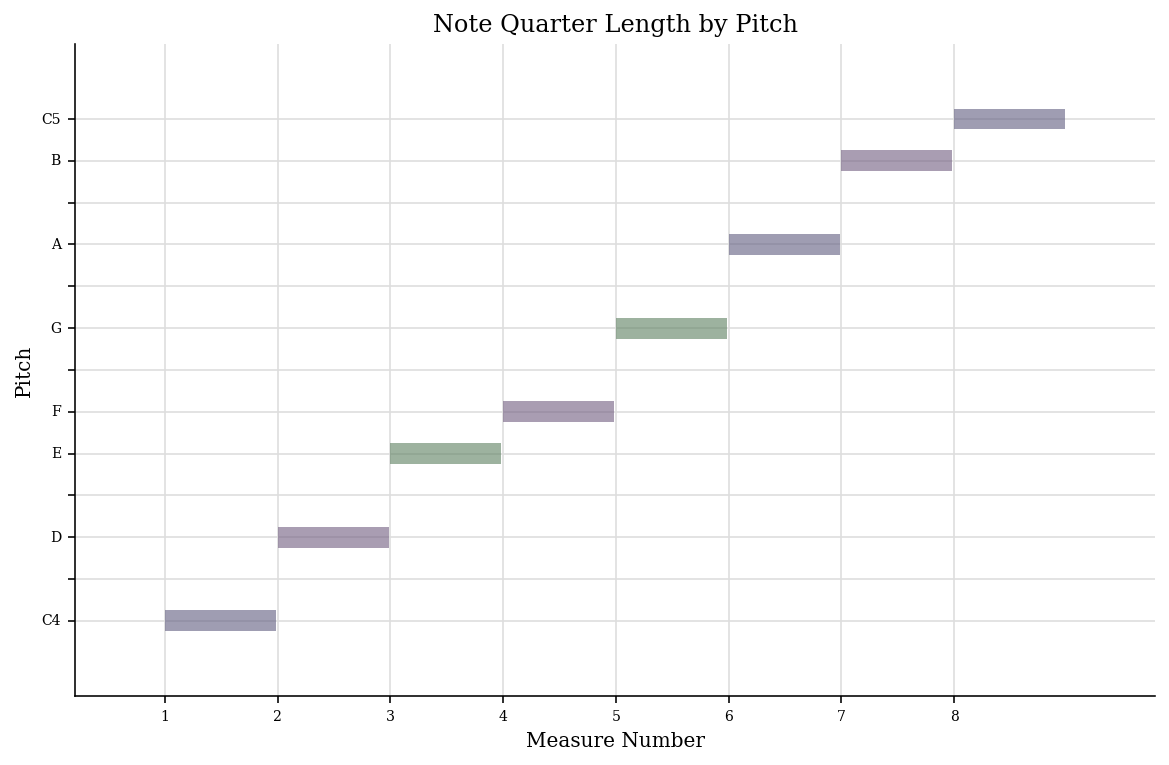

In [92]:
test_scale_df = encoded_song[encoded_song.index=='Piano']
decode_data(test_scale_df, N_FRAMES).plot()

In [93]:
def create_decoded_song(bars, infos):
    num_bars = bars.shape[0]
    columns = [key_index2note(i, MIDI_OFFSET).nameWithOctave for i in range(bars.shape[2])]
    df_decoded_song = pd.DataFrame([], columns=columns)
    
    for idx_bar in range(num_bars):
        indexes = [infos.index[0] for i in range(bars[idx_bar].shape[0])]
        df_decoded_bar = pd.DataFrame(bars[idx_bar], columns=columns).set_index(pd.Index(indexes)) 
        df_decoded_song = df_decoded_song.append(df_decoded_bar) 

    df_decoded_song.index.name = 'inst'
    output = pd.concat([infos, df_decoded_song], axis=1)
    return output

In [94]:
def create_decoded_bar(bar, infos):

    columns = [key_index2note(i, MIDI_OFFSET).nameWithOctave for i in range(bar.shape[1])]

    indexes = [infos.index[0] for i in range(bar.shape[0])]
    df_decoded_bar = pd.DataFrame(bar, columns=columns).set_index(pd.Index(indexes))
    df_decoded_bar.index.name = 'inst'
    print(infos.shape, df_decoded_bar.shape)
    output = pd.concat([infos, df_decoded_bar], axis=1)
    return output


## Previous

Decoding instrument: Piano
Took 0.3238942623138428


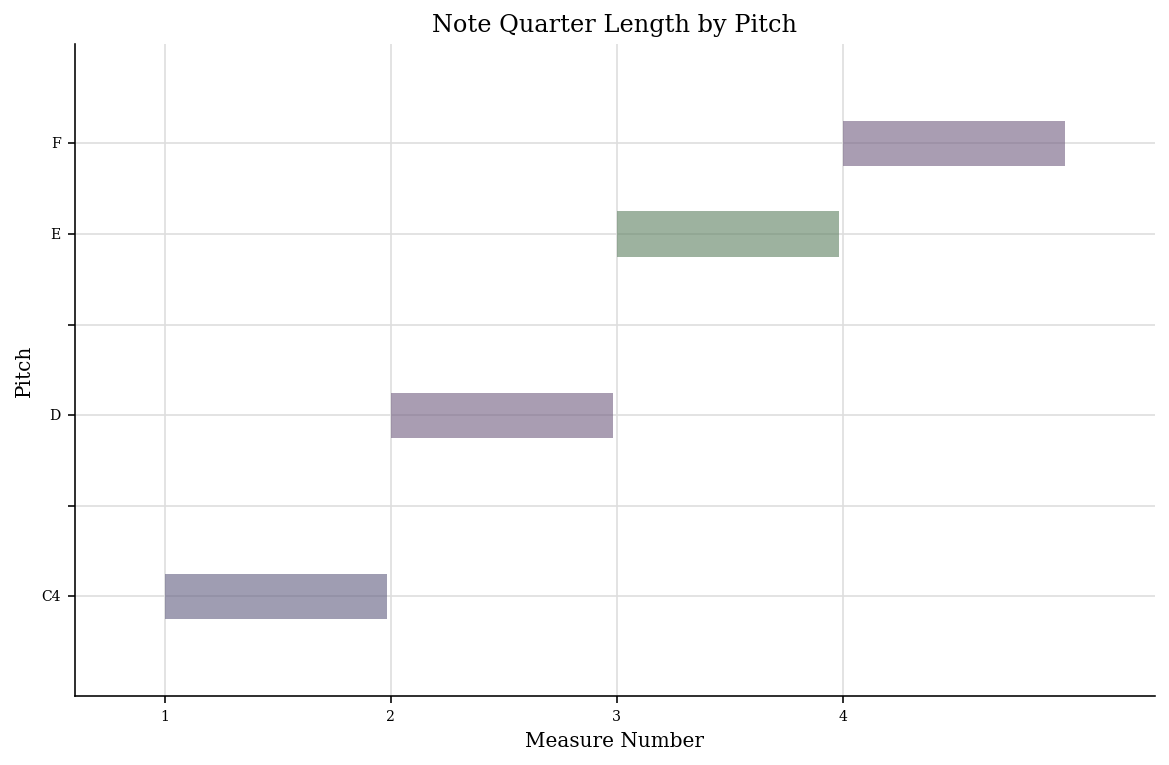

In [98]:
first = 0
last = 7

previous = test_scale_df.iloc[0:N_FRAMES*last]
s_previous = decode_data(previous, N_FRAMES)

s_previous.plot()

## Gerated Output

F4 0.9999985694885254 C5 1.8434182180726566e-08
F4 0.9999994039535522 C5 4.5198540021829103e-08
F4 0.9999995231628418 C5 6.129199903170957e-08
F4 0.9999995231628418 C5 6.470824587267998e-08
F4 0.9999995231628418 C5 6.030827393033178e-08
F4 0.9999995231628418 C5 6.255537954302781e-08
F4 0.9999995231628418 C5 6.200964008939991e-08
F4 0.9999995231628418 C5 6.307715949560588e-08
F4 0.9999995231628418 C5 6.153869946956547e-08
F4 0.9999995231628418 C5 6.270040131539645e-08
F4 0.9999995231628418 C5 6.214865067022401e-08
F4 0.9999995231628418 C5 6.262092000497432e-08
F4 0.9999995231628418 C5 6.206774116890301e-08
F4 0.9999995231628418 C5 6.255800855115012e-08
F4 0.9999995231628418 C5 6.218078141273509e-08
F4 0.9999995231628418 C5 6.237999627956015e-08
F4 0.9999995231628418 C5 6.207046254758097e-08
F4 0.9999995231628418 C5 6.217852899226273e-08
F4 0.9999995231628418 C5 6.185985057527432e-08
F4 0.9999995231628418 C5 6.17853288531478e-08
F4 0.9999995231628418 C5 6.137575780940097e-08
F4 0.9999995

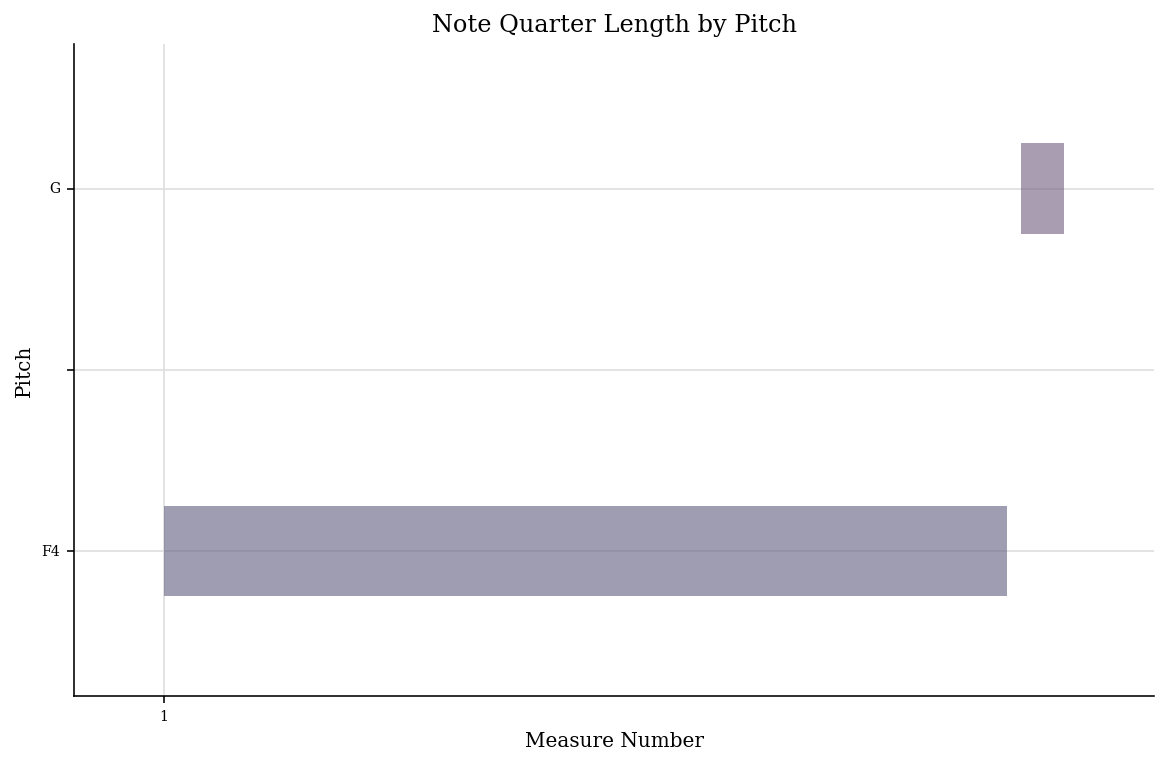

In [99]:
output = generate(model, previous, N_FRAMES, temperature=0.5)
output_info = get_info(test_piano_df[-(1+N_FRAMES):-1], N_FRAMES)
output_df = create_decoded_bar(output, output_info)
s_output = decode_data(output_df, N_FRAMES)

try:    s_output.plot()
except Exception as e: print(e)

## Previous + Gerated Output

Decoding instrument: Piano
Took 0.23093152046203613


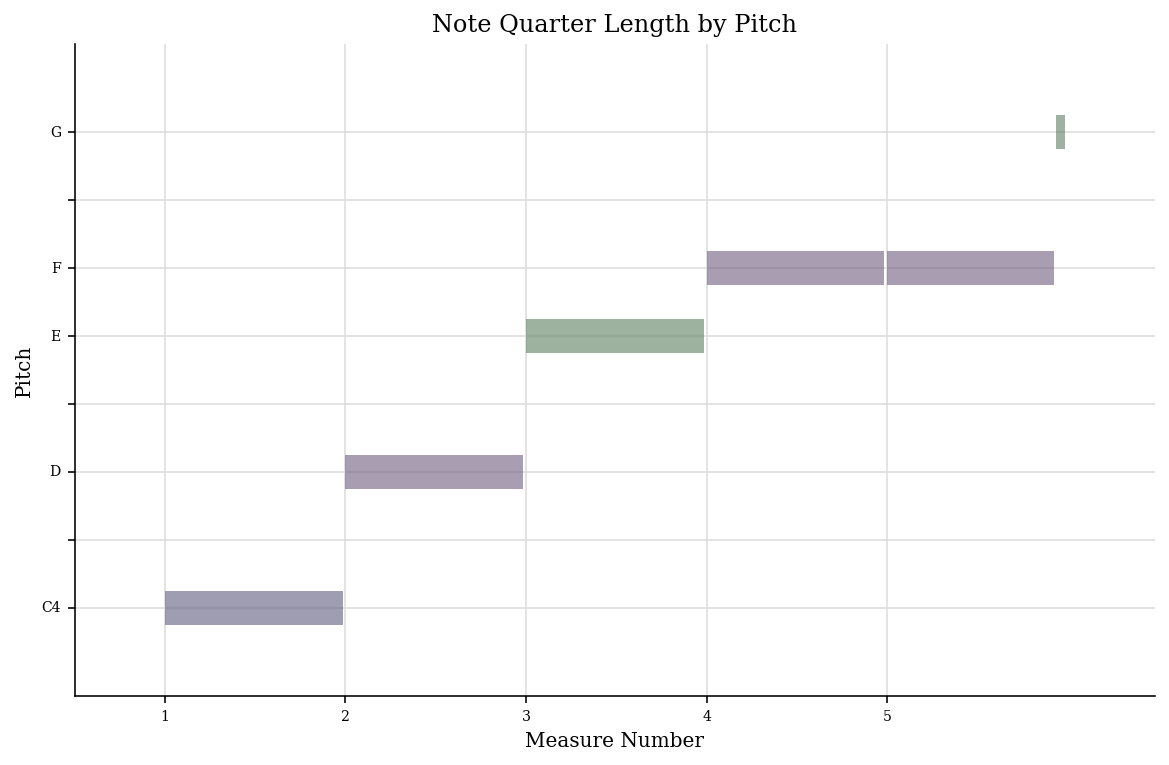

In [100]:
concat_output = pd.concat([previous, output_df], axis=0)
s_concat_output = decode_data(concat_output, N_FRAMES)
s_concat_output.plot()

